In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("VR_adop_data.csv")

In [3]:
missing_before = df.isna().sum().sum()
print(f"Missing values before cleaning: {missing_before}")
# Select key variables and remove incomplete records
df = df[['vr_type', 'online_spend', 'total_spend', 'average_open_hours', 'category']].dropna()
missing_after = df.isna().sum().sum()
print(f"Missing values after cleaning: {missing_after}\n")

# Filter invalid numeric values to remove unrealistic or zero entries
df = df[(df['online_spend'] > 0) & (df['total_spend'] > 0)].copy()
# Create a new derived continuous variable for analysis
df['online_ratio'] = (df['online_spend'] / df['total_spend']).clip(0, 1)
# Convert identifiers into categorical types for efficient grouping
df[['vr_type', 'category']] = df[['vr_type', 'category']].astype('category')
# Display current data type summary
print(df.dtypes)

Missing values before cleaning: 24379
Missing values after cleaning: 0

vr_type               category
online_spend           float64
total_spend            float64
average_open_hours     float64
category              category
online_ratio           float64
dtype: object


In [4]:
# Custom function: Categorize platforms
def categorize_platform(vr):
    groups = {
        '3D/AR Creation': {'8th Wall','A-Frame','Model Viewer','Cloudpano','PanoSkin'},
        'Enterprise Tools': {'WalkMe','WhatFix','Virtual SmileSnap'},
        'VR Advertising': {'ARitize','ZapWorks','ViewAR','echoAR'},
        'Immersive Experience': {'VRChat','Spatial','AltspaceVR','Horizon Worlds'}
    }
    for name, items in groups.items():
        if vr in items: return name
    return 'Others' if pd.notna(vr) and vr.strip() else 'Unknown'

# Categorize VR type into platform groups
df['Platform_Group'] = df['vr_type'].astype(str).apply(categorize_platform)

In [5]:
# Define a function that summarizes online spending ratios by platform group
def summarize_ratio(data):
    summary = (data.groupby('Platform_Group')['online_ratio'] # Group by VR platform
               .agg(['mean', 'std', 'count']) # Calculate mean, std deviation, count
               .reset_index())
    summary['sem'] = summary['std'] / np.sqrt(summary['count']) # SEM=sd/sqrt(n)
    return summary.round(3)

summary = summarize_ratio(df)
print(summary)

     Platform_Group   mean    std  count    sem
0    3D/AR Creation  0.308  0.389   2046  0.009
1  Enterprise Tools  0.187  0.360    750  0.013
2            Others  0.257  0.371    756  0.013


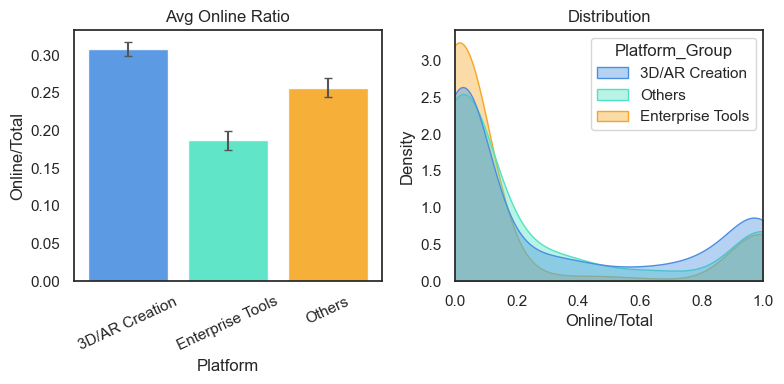

In [6]:
# Visualization
sns.set(style="white")
palette = ['#4A90E2', '#50E3C2', '#F5A623']
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
# 1. Bar Chart with Error Bars: compares group means
axes[0].bar(summary['Platform_Group'], summary['mean'],
            yerr=summary['sem'], color=palette[:len(summary)],
            alpha=0.9, error_kw=dict(ecolor='#555', capsize=3))
axes[0].set(title='Avg Online Ratio', xlabel='Platform', ylabel='Online/Total')
axes[0].tick_params(axis='x', rotation=25)
# 2. KDE distributions: reveals within-group variation
sns.kdeplot(data=df, x='online_ratio', hue='Platform_Group',
            fill=True, alpha=0.4, ax=axes[1], palette=palette,
            common_norm=False)
axes[1].set(title='Distribution', xlabel='Online/Total', ylabel='Density', xlim=(0, 1))

plt.tight_layout()
plt.show()